In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchrl.envs.libs.gym import GymEnv
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torchrl.modules import ProbabilisticActor, TanhNormal

from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_cells = 256

In [3]:
def build_policy_module(env):
    """
    Build the policy network exactly as used in training.
    """
    actor_net = nn.Sequential(
        nn.LazyLinear(num_cells, device=device),
        nn.Tanh(),
        nn.LazyLinear(num_cells, device=device),
        nn.Tanh(),
        nn.LazyLinear(num_cells, device=device),
        nn.Tanh(),
        # The last layer outputs 2 * action_dim (for loc and scale)
        nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
        NormalParamExtractor(),
    )
    # Wrap the actor net in a TensorDictModule.
    policy_td_module = TensorDictModule(actor_net, in_keys=["observation"], out_keys=["loc", "scale"])
    policy_module = ProbabilisticActor(
        module=policy_td_module,
        spec=env.action_spec,
        in_keys=["loc", "scale"],
        distribution_class=TanhNormal,
        distribution_kwargs={
            "low": env.action_spec.space.low,
            "high": env.action_spec.space.high,
        },
        return_log_prob=True,
    )
    return policy_module

In [4]:
def main(env_name, method='PPO'):
    # Use render_mode "rgb_array" so we can capture image arrays for screenshots.
    render_env = GymEnv(env_name, device=device, render_mode="rgb_array")
    
    # Build the policy module
    print("Building policy module ...")
    policy_module = build_policy_module(render_env)
    
    # Load the checkpoint
    print('Loading checkpoint ...')
    checkpoint_path = f"../runs/{method}/{method}_{env_name}_1_1000000.pth"
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    policy_module.load_state_dict(checkpoint["policy_state_dict"])
    policy_module.to(device)
    policy_module.eval()
    print('Checkpoint loaded.')
    # Reset the environment and initialize variables
    tensordict = render_env.reset()
    done = False
    frames = []  # list to store frames for screenshots
    
    # Run an episode using the loaded policy
    print('Running an episode for 300 steps ...')
    with torch.no_grad():
        for _ in tqdm(range(300)):
            # Ensure the observation is in float32 (if not already)
            tensordict["observation"] = tensordict["observation"].to(torch.float32)
            action = policy_module(tensordict)
            tensordict = render_env.step(action)
            
            # Capture the rendered frame (an RGB array)
            frame = render_env.render()
            frames.append(frame)
            
            time.sleep(0.02)  # small delay for smooth visualization
            
            # Check if the episode has ended
            done = tensordict["done"].item()
    
    render_env.close()
    
    # Determine indices for 10 evenly spaced screenshots over the episode
    num_shots = 10
    if len(frames) < num_shots:
        print("Episode length shorter than 10 frames; using all available frames.")
        indices = range(len(frames))
    else:
        indices = np.linspace(0, len(frames) - 1, num_shots, dtype=int)
    
    # Create a grid of images (5 rows x 2 columns)
    fig, axs = plt.subplots(5, 2, figsize=(10, 20))
    axs = axs.flatten()
    
    for i, idx in enumerate(indices):
        axs[i].imshow(frames[idx])
        axs[i].axis("off")
        axs[i].set_title(f"Timestep: {idx}", fontsize=10)
    
    plt.tight_layout()
    
    # Create output directory for the grid image
    os.makedirs("figures", exist_ok=True)
    grid_path = os.path.join("figures", f"grid_{env_name[:-3]}_{method}.png")
    plt.savefig(grid_path, dpi=150)
    print(f"Saved grid of screenshots to {grid_path}")

Building policy module ...
Loading checkpoint ...
Checkpoint loaded.
Running an episode for 300 steps ...


100%|██████████| 300/300 [00:08<00:00, 36.85it/s]


Saved grid of screenshots to figures/grid_Walker2d_PPO.png


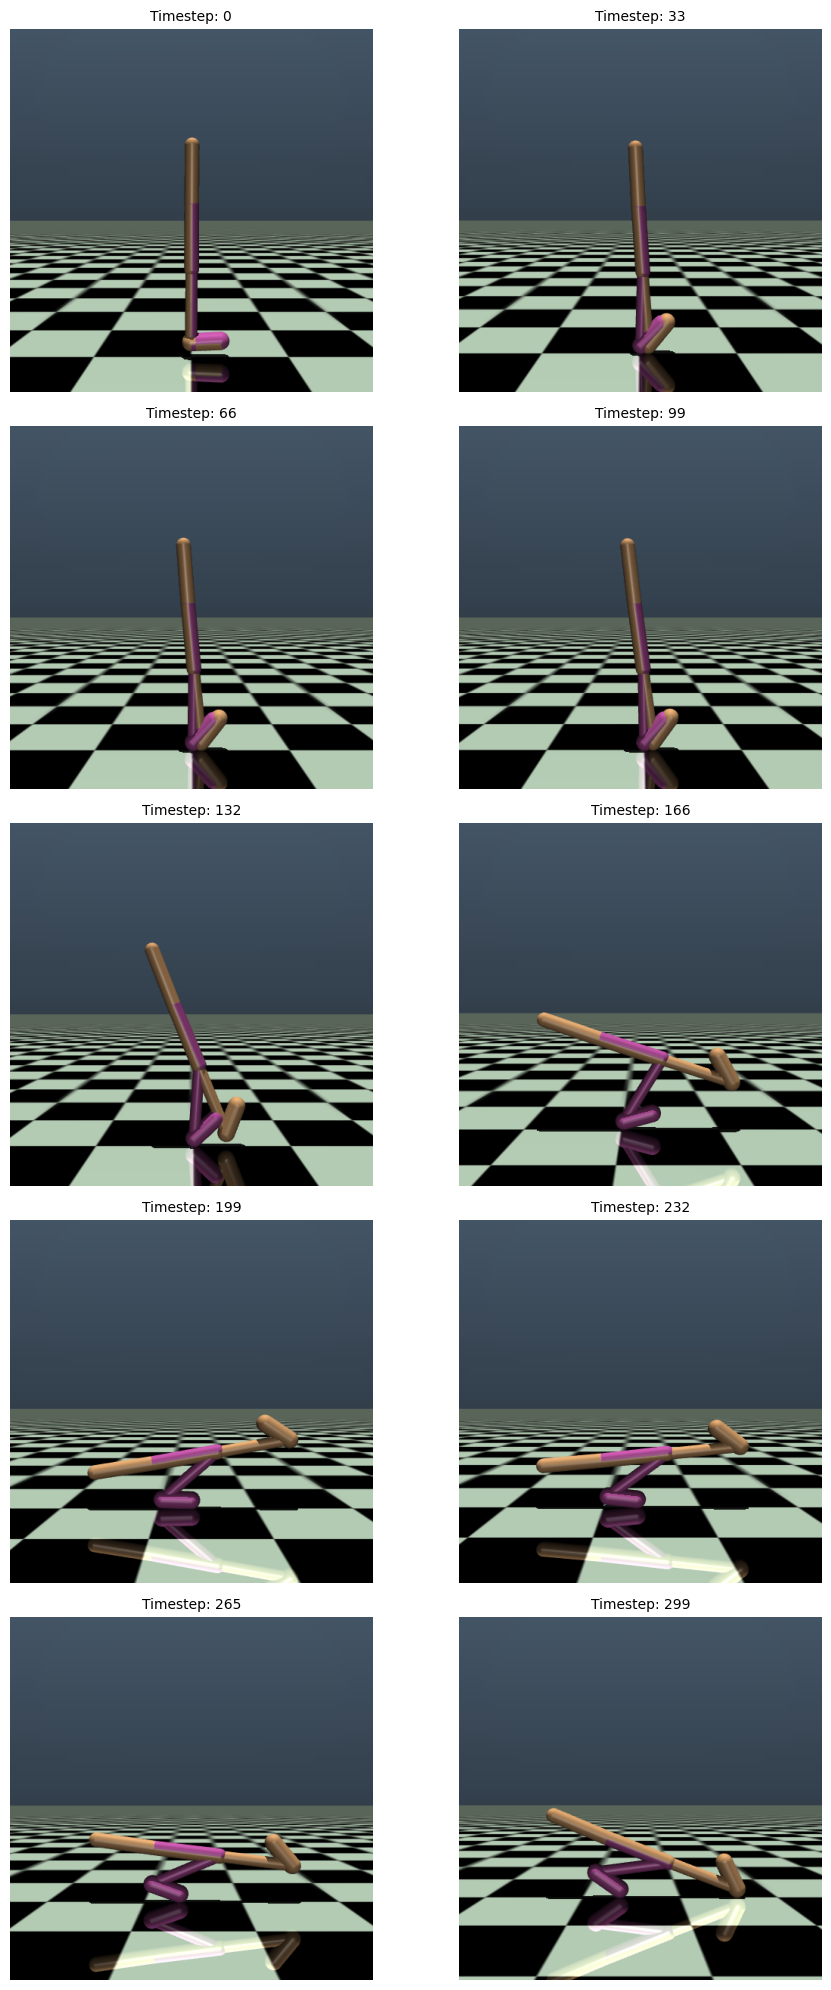

In [5]:
main("Walker2d-v4")

Building policy module ...
Loading checkpoint ...
Checkpoint loaded.
Running an episode for 300 steps ...


100%|██████████| 300/300 [00:08<00:00, 37.27it/s]


Saved grid of screenshots to figures/grid_Walker2d_A2C.png


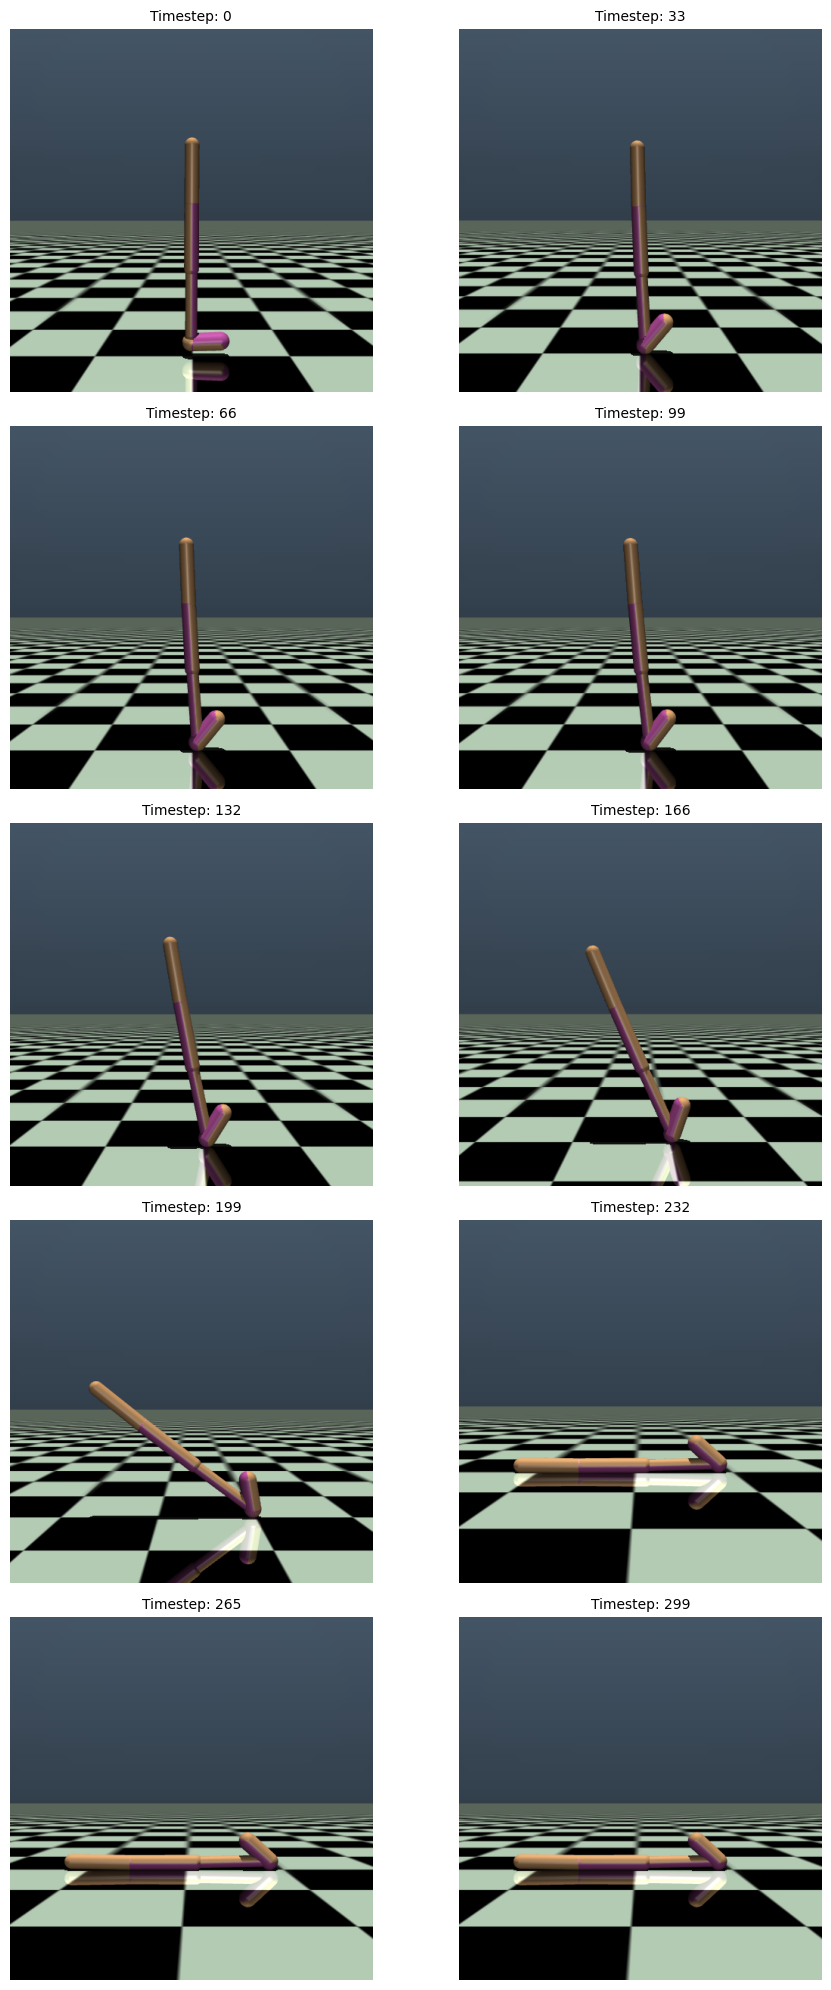

In [6]:
main("Walker2d-v4", 'A2C')